# Power spectrum covariance matrix plots (analytic and EZmocks-based)

In [1]:
import os
import sys

import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import Normalize
import matplotlib.ticker as ticker

sys.path.append('../bin')
from cov_utils import truncate_cov, get_EZmocks_covariance, cov_to_corrcoef, plot_corrcoef

# plotting
plt.style.use(os.path.join(os.path.abspath('../bin'), 'plot_style.mplstyle'))
plt.rcParams["figure.autolayout"] = False
plots_dir = '../../plots/'

### Global parameters

In [2]:
# tracer
tracer = 'ELG_LOPnotqso'
region = 'SGC'
completeness = True
zmin = 1.1
zmax = 1.6

# multipoles
ells = (0, 2, 4)
klim = (0., 0.4)

# cut
rpcut = 0
thetacut = 0.05

### Load covariance

In [4]:
# Analytic
analytic_cov_fn = '/global/cfs/cdirs/desi/users/mpinon/Y1/cov/pk/cov_gaussian_pre_{}_{}_{:.1f}_{:.1f}_default_FKP_lin.txt'.format(tracer, region, zmin, zmax)
analytic_cov = np.loadtxt(analytic_cov_fn)
analytic_cov = truncate_cov(analytic_cov, kinit=np.arange(0., 0.4, 0.005), kfinal=np.arange(klim[0], klim[1], 0.005))
analytic_corrcoef = cov_to_corrcoef(analytic_cov)

# EZmocks
#ezmocks_cov = get_EZmocks_covariance(stat='pkpoles', tracer=tracer, region=region, zrange=(zmin, zmax), completeness='ffa', ells=(0, 2, 4), select=(klim[0], klim[1], 0.005), rpcut=rpcut, thetacut=thetacut, return_x=False, hartlap=False)
cov_fn = '/global/cfs/cdirs/desi/users/mpinon/Y1/cov/pk/cov_EZmocks_{}_ffa_{}_z{:.3f}-{:.3f}_k{:.2f}-{:.2f}{}.npy'.format(tracer[:7], region, zmin, zmax, klim[0], klim[1], '_thetacut{:.2f}'.format(thetacut) if thetacut else '')
ezmocks_cov = np.load(cov_fn)
#np.save(cov_fn, ezmocks_cov)
#ezmocks_cov = truncate_cov(ezmocks_cov, kinit=np.arange(0., 0.520, 0.005), kfinal=np.arange(klim[0], klim[1], 0.005))
ezmocks_corrcoef = cov_to_corrcoef(ezmocks_cov)

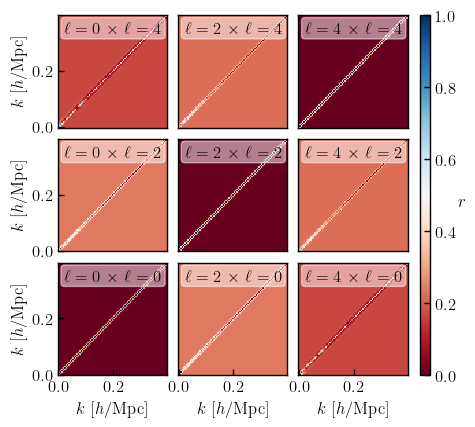

In [6]:
plot_corrcoef(analytic_cov, ells, np.arange(klim[0], klim[1], 0.005))
plt.show()

In [5]:
def plot_corrcoef(cov, ells, k, norm=None):
    stddev = np.sqrt(np.diag(cov).real)
    corrcoef = cov / stddev[:, None] / stddev[None, :]

    nk = len(k)
    nells = len(ells)

    fig, lax = plt.subplots(nrows=nells, ncols=nells, sharex=False, sharey=False, figsize=(5, 4.5), squeeze=False)
    #fig.subplots_adjust(wspace=0.1, hspace=0.1)

    from matplotlib import colors
    norm = colors.TwoSlopeNorm(vmin=-1, vcenter=0., vmax=1) if norm is None else norm

    for i in range(nells):
        for j in range(nells):
            ax = lax[nells-1-i][j]
            mesh = ax.pcolor(k, k, corrcoef[i*nk:(i+1)*nk,j*nk:(j+1)*nk].T, norm=None, cmap=plt.get_cmap('RdBu'))
            if i>0: ax.xaxis.set_visible(False)
            else: ax.set_xlabel(r'$k$  [$h$/Mpc]')
            if j>0: ax.yaxis.set_visible(False)
            else: ax.set_ylabel(r'$k$  [$h$/Mpc]')
            text = r'{} $\times$ {}'.format(r'$\ell={}$'.format(ells[j % nells]), r'$\ell={}$'.format(ells[i]))
            props = dict(facecolor='white', alpha=0.5, edgecolor='white', boxstyle="Round, pad=0.2")
            ax.text(0.05, 0.95, text, horizontalalignment='left', verticalalignment='top', transform=ax.transAxes, color='black', fontsize=12, bbox=props)
            ax.grid(False)
        
    fig.subplots_adjust(left=0.15, right=0.85, bottom=0.15)
    cbar_ax = fig.add_axes([0.875, 0.15, 0.02, 0.8])
    cbar = fig.colorbar(mesh, cax=cbar_ax)
    cbar.set_label(r'$r$', rotation=0)
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    return lax

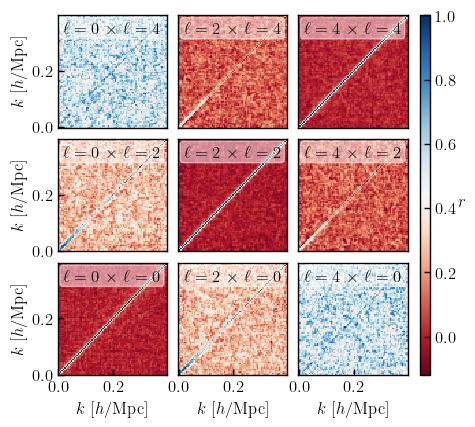

In [6]:
plot_corrcoef(ezmocks_cov, ells, np.arange(klim[0], klim[1], 0.005))
plt.savefig(os.path.join(plots_dir, 'cov_ezmocks_{}cut{}_{}_{}_z{:.2f}-{:.2f}.png'.format('rp' if rpcut else 'theta', max(rpcut, thetacut), tracer, region, zmin, zmax)), dpi=300)
plt.show()

In [7]:
### Add artificial noise to the analytical covariance
from numpy import random

fake_data = random.multivariate_normal(np.zeros(analytic_cov.shape[0]), analytic_cov, size=1000)

/tmp/ipykernel_2274372/186405203.py:4: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  fake_data = random.multivariate_normal(np.zeros(analytic_cov.shape[0]), analytic_cov, size=1000)


In [8]:
noisy_cov = np.cov(fake_data, rowvar=False, ddof=1)

# Hartlap correction
nmocks = 1000
nk = analytic_cov.shape[0]
hartlap = (nmocks - nk - 2) / (nmocks - 1)
noisy_cov /= hartlap

noisy_cov_fn = '/global/cfs/cdirs/desi/users/mpinon/Y1/cov/noisy_cov_gaussian_pre_{}_{}_{:.1f}_{:.1f}_default_FKP_lin.txt'.format(tracer, region, zmin, zmax)
np.savetxt(noisy_cov_fn, noisy_cov)

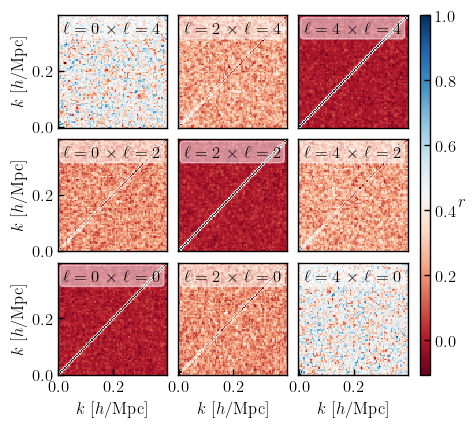

In [9]:
plot_corrcoef(noisy_cov, ells, np.arange(klim[0], klim[1], 0.005))
plt.show()

### PCA to smooth the EZmocks covariance matrix

In [10]:
from pypower import PowerSpectrumMultipoles
from desi_file_manager import DESIFileName

poles_list = []
for i in range(1, 1001):
    pk = PowerSpectrumMultipoles.load(DESIFileName().set_default_config(mocktype='SecondGenMocks/EZmock', version='v1', ftype='pkpoles', tracer=tracer, zrange=(1.1, 1.6), completeness='ffa').get_path(realization=i, region=region,  thetacut=thetacut))
    poles = pk.select((klim[0], klim[1], 0.005))(ell=ells, complex=False).ravel()
    k = pk.k
    poles_list.append(poles)

In [11]:
x = np.array(poles_list)
x.shape

(1000, 240)

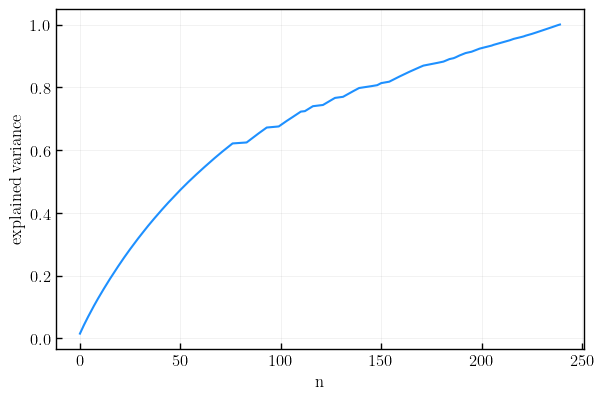

In [12]:
x = (x - np.mean(x, axis=0))/np.std(x, axis=0)
c = np.cov(x, rowvar=False, ddof=1)
eig_vals, eig_vecs = np.linalg.eig(c)
explained_var = np.cumsum(eig_vals)/np.sum(eig_vals)
plt.plot(explained_var)
plt.xlabel('n')
plt.ylabel('explained variance')
plt.show()

In [13]:
def pca(x, n=1):
    x = (x - np.mean(x, axis=0))/np.std(x, axis=0)
    c = np.cov(x, rowvar=False, ddof=1)
    eig_vals, eig_vecs = np.linalg.eig(c)
    y = (x.dot(eig_vecs[:, :n])).dot(eig_vecs[:, :n].T)
    return y

In [14]:
xpca = pca(x, n=200)

In [24]:
newcov = np.cov(xpca, rowvar=False, ddof=1)
covnew_fn = '/global/cfs/cdirs/desi/users/mpinon/Y1/cov/pk/cov_EZmocks_PCA200_{}_ffa_{}_z{:.3f}-{:.3f}_k{:.2f}-{:.2f}{}.npy'.format(tracer[:7], region, zmin, zmax, klim[0], klim[1], '_thetacut{:.2f}'.format(thetacut) if thetacut else '')
np.save(covnew_fn, newcov)

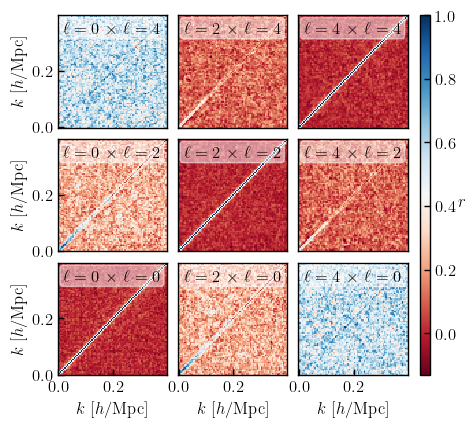

In [16]:
plot_corrcoef(newcov, ells, np.arange(klim[0], klim[1], 0.005))
plt.show()

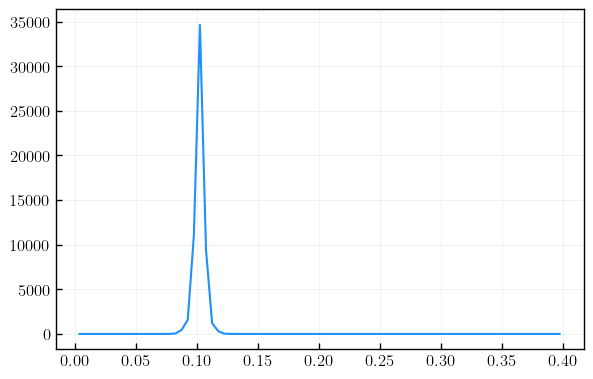

In [17]:
plt.plot(k, analytic_cov[20, :80])
plt.show()

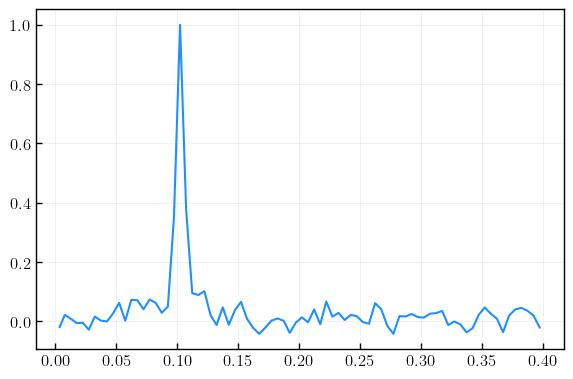

In [18]:
stddev = np.sqrt(np.diag(ezmocks_cov).real)
corrcoef = ezmocks_cov / stddev[:, None] / stddev[None, :]
plt.plot(k, corrcoef[20, :80])
plt.show()

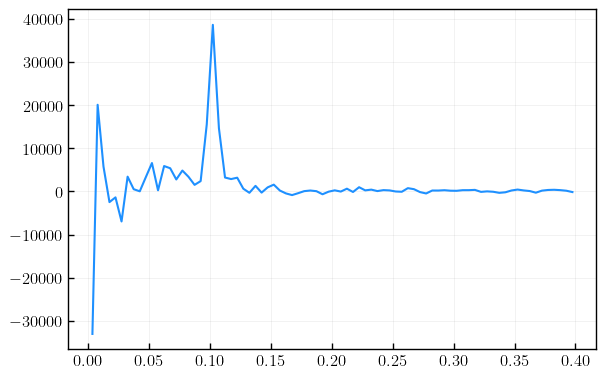

In [19]:
plt.plot(k, ezmocks_cov[20, :80])
plt.show()

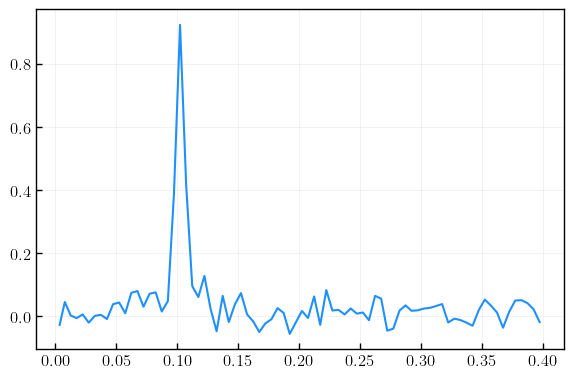

In [20]:
plt.plot(k, newcov[20, :80])
plt.show()

In [21]:
import scipy.ndimage as ndi
kernel = np.full((5, 5), 1/25.)
smooth_ezmocks_cov = ndi.correlate(ezmocks_cov, kernel)

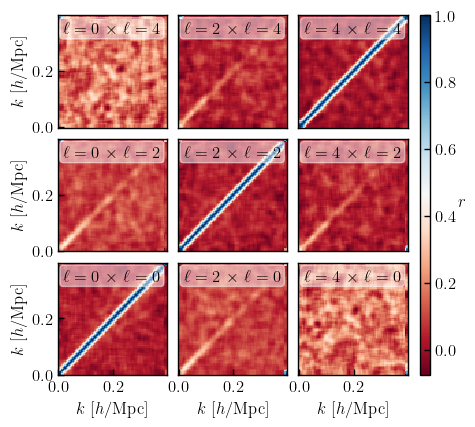

In [22]:
plot_corrcoef(smooth_ezmocks_cov, ells, np.arange(klim[0], klim[1], 0.005))
plt.show()

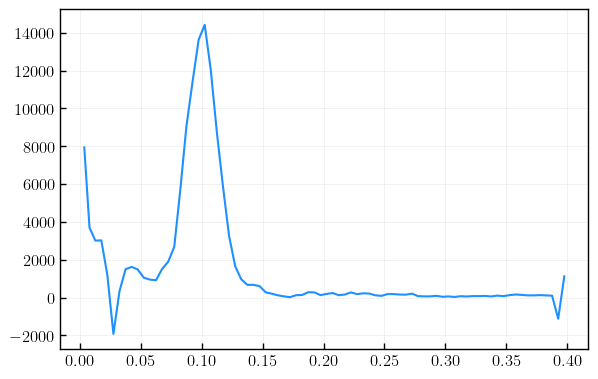

In [23]:
plt.plot(k, smooth_ezmocks_cov[20, :80])
plt.show()